# ResNet64 Sleep-Apnea Classification: Implementation & Evaluation

In [ ]:
# ===========================
# 1. IMPORTS & DRIVE SETUP
# ===========================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchsummary import summary

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ======================
# 2. DATA PREPARATION
# ======================

# Define transformations to apply to each spectrogram image:
#   1. Resize to 224×224 (ResNet50 expects 224×224 inputs)
#   2. Convert PIL image to PyTorch tensor (pixel values → [0.0, 1.0])
#   3. Normalize channels using ImageNet mean/std so pretrained filters work well
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet channel means
        std=[0.229, 0.224, 0.225]    # ImageNet channel standard deviations
    )
])

# Base directory in Google Drive where train/val/test data folders reside
data_dir = "/content/drive/MyDrive/spectrograms_split"

# Load folders of images—PyTorch will assign numeric labels based on subfolder names
train_dataset    = datasets.ImageFolder(os.path.join(data_dir, 'train'),    transform=transform)
val_dataset      = datasets.ImageFolder(os.path.join(data_dir, 'val'),      transform=transform)
test_dataset     = datasets.ImageFolder(os.path.join(data_dir, 'test'),     transform=transform)
balanced_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test_balanced'), transform=transform)

# Wrap each dataset in a DataLoader for batching and shuffling
batch_size  = 32
num_workers = 4  # number of CPU threads used for data loading

train_loader    = DataLoader(train_dataset,    batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader      = DataLoader(val_dataset,      batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader     = DataLoader(test_dataset,     batch_size=batch_size, shuffle=False, num_workers=num_workers)
balanced_loader = DataLoader(balanced_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# ======================
# 3. MODEL DEFINITION
# ======================

class ResNet64(nn.Module):
    """
    ResNet64 wraps a pretrained ResNet-50 from torchvision and
    replaces its final fully-connected layer so it outputs exactly 4 classes:
      0 = normal, 1 = mild, 2 = moderate, 3 = severe (sleep-apnea severity).
    """
    def __init__(self, num_classes=4):
        super(ResNet64, self).__init__()
        # Load a ResNet-50 pretrained on ImageNet
        self.model = models.resnet50(pretrained=True)
        # Replace the final 'fc' layer (which originally had 1000 outputs)
        # with a new Linear layer that outputs 'num_classes' logits.
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Instantiate the model and move it to GPU/CPU
num_classes = len(train_dataset.classes)  # should be 4
model = ResNet64(num_classes=num_classes).to(device)

# Print a summary of the architecture (input size 3×224×224)
summary(model, input_size=(3, 224, 224))

# Define loss function and optimizer:
#   - We use CrossEntropyLoss for multi-class classification.
#   - Adam optimizer with learning rate = 1e-4 is used for weight updates.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# ==========================
# 4. PLOTTING STYLE SETUP
# ==========================

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.0)

In [ ]:
# ===================
# 5. TRAINING LOOP
# ===================

num_epochs = 20

for epoch in range(num_epochs):
    model.train()        # set model to training mode (enables dropout/BatchNorm updates)
    running_loss = 0.0   # accumulate loss to compute average per epoch

    for images, labels in train_loader:
        # Move data to GPU/CPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass → compute logits
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # clear any previously stored gradients
        loss.backward()        # compute gradients of loss w.r.t. model params
        optimizer.step()       # update model parameters

        running_loss += loss.item()

    # Compute and print average loss for this epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 0.7360
Epoch [2/20], Loss: 0.3583
Epoch [3/20], Loss: 0.2233
Epoch [4/20], Loss: 0.1202
Epoch [5/20], Loss: 0.1148
Epoch [6/20], Loss: 0.0829
Epoch [7/20], Loss: 0.0703
Epoch [8/20], Loss: 0.0777
Epoch [9/20], Loss: 0.0581
Epoch [10/20], Loss: 0.0646
Epoch [11/20], Loss: 0.0478
Epoch [12/20], Loss: 0.0329
Epoch [13/20], Loss: 0.0556
Epoch [14/20], Loss: 0.0497
Epoch [15/20], Loss: 0.0371
Epoch [16/20], Loss: 0.0323
Epoch [17/20], Loss: 0.0429
Epoch [18/20], Loss: 0.0291
Epoch [19/20], Loss: 0.0355
Epoch [20/20], Loss: 0.0269


In [ ]:
# ===========================
# 6. VALIDATION EVALUATION
# ===========================

model.eval()  # switch model to evaluation mode (disables dropout, fixes BatchNorm stats)

all_preds_val  = []  # store predicted labels for each batch
all_labels_val = []  # store true labels

correct_val, total_val = 0, 0  # track correct predictions and total samples

with torch.no_grad():  # disable gradient computations for speed
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass → logits
        outputs = model(images)
        _, predicted = torch.max(outputs, dim=1)  # get index of max logit per sample

        total_val   += labels.size(0)
        correct_val += (predicted == labels).sum().item()

        # Move predictions/labels to CPU and append
        all_preds_val.append(predicted.cpu())
        all_labels_val.append(labels.cpu())

accuracy_val = 100 * correct_val / total_val
print(f"\nValidation Accuracy: {accuracy_val:.2f}%")

# Concatenate all batches into single NumPy arrays for metric calculations
all_preds_val  = torch.cat(all_preds_val).numpy()
all_labels_val = torch.cat(all_labels_val).numpy()

precision_val = precision_score(all_labels_val, all_preds_val, average='macro', zero_division=0)
recall_val    = recall_score(all_labels_val, all_preds_val, average='macro', zero_division=0)
f1_val        = f1_score(all_labels_val, all_preds_val, average='macro', zero_division=0)

print(f"Validation Precision (macro): {precision_val:.4f}")
print(f"Validation Recall    (macro): {recall_val:.4f}")
print(f"Validation F1-Score   (macro): {f1_val:.4f}\n")

print("Validation: Per-class Precision / Recall / F1:\n")
print(classification_report(
    all_labels_val,
    all_preds_val,
    target_names=train_dataset.classes,  # e.g. ['normal','mild','moderate','severe']
    zero_division=0
))

cm_val = confusion_matrix(all_labels_val, all_preds_val)
print("Validation Confusion Matrix (rows=true, cols=predicted):")
print(cm_val)


Validation Accuracy: 89.23%
Validation Precision (macro): 0.8973
Validation Recall    (macro): 0.8731
Validation F1-Score   (macro): 0.8844

Validation: Per-class Precision / Recall / F1:

              precision    recall  f1-score   support

        mild       0.88      0.93      0.90      1260
    moderate       0.89      0.84      0.86       740
      normal       0.91      0.83      0.87       123
      severe       0.91      0.89      0.90       978

    accuracy                           0.89      3101
   macro avg       0.90      0.87      0.88      3101
weighted avg       0.89      0.89      0.89      3101

Validation Confusion Matrix (rows=true, cols=predicted):
[[1167   37    3   53]
 [  83  624    6   27]
 [   7   11  102    3]
 [  71   32    1  874]]


In [ ]:
# =====================
# 7. TEST EVALUATION
# =====================

model.eval()

all_preds_test  = []
all_labels_test = []
all_probs_test  = []
correct_test, total_test = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass → raw logits
        outputs = model(images)
        # Convert logits to probabilities via softmax (needed for ROC/PR)
        probs = torch.softmax(outputs, dim=1)
        # Hard prediction = index of maximum logit
        _, predicted = torch.max(outputs, dim=1)

        total_test   += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Move data back to CPU and store
        all_preds_test.append(predicted.cpu())
        all_labels_test.append(labels.cpu())
        all_probs_test.append(probs.cpu())

accuracy_test = 100 * correct_test / total_test
print(f"\nTest Accuracy: {accuracy_test:.2f}%")

# Concatenate per-batch results into NumPy arrays
all_preds_test  = torch.cat(all_preds_test).numpy()
all_labels_test = torch.cat(all_labels_test).numpy()
all_probs_test  = torch.cat(all_probs_test).numpy()  # shape = (N_samples, 4)

precision_test = precision_score(all_labels_test, all_preds_test, average='macro', zero_division=0)
recall_test    = recall_score(all_labels_test, all_preds_test, average='macro', zero_division=0)
f1_test        = f1_score(all_labels_test, all_preds_test, average='macro', zero_division=0)

print(f"Test Precision (macro): {precision_test:.4f}")
print(f"Test Recall    (macro): {recall_test:.4f}")
print(f"Test F1-Score   (macro): {f1_test:.4f}\n")

print("Test: Per-class Precision / Recall / F1:\n")
print(classification_report(
    all_labels_test,
    all_preds_test,
    target_names=test_dataset.classes,
    zero_division=0
))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Test Accuracy: 88.25%
Test Precision (macro): 0.8869
Test Recall    (macro): 0.8533
Test F1-Score   (macro): 0.8686

Test: Per-class Precision / Recall / F1:

              precision    recall  f1-score   support

        mild       0.87      0.91      0.89      1262
    moderate       0.88      0.82      0.85       741
      normal       0.90      0.77      0.83       124
      severe       0.91      0.90      0.91       979

    accuracy                           0.88      3106
   macro avg       0.89      0.85      0.87      3106
weighted avg       0.88      0.88      0.88      3106



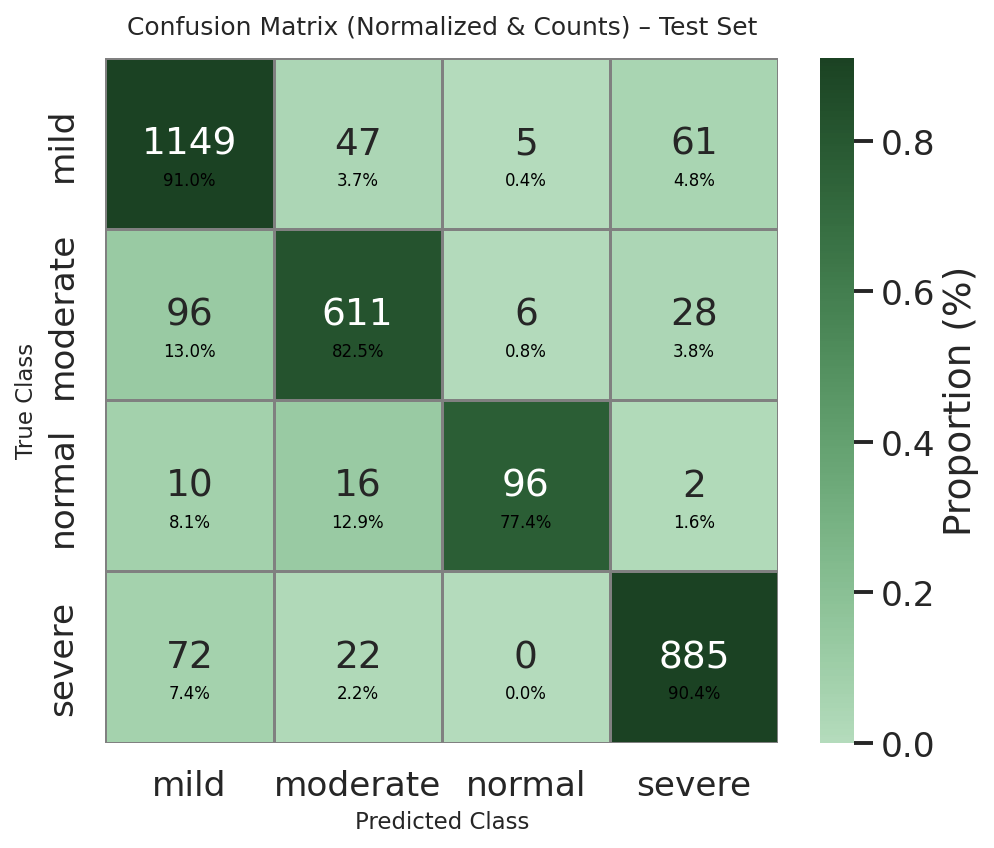

In [ ]:
# ====================================
# 7a. Confusion Matrix for Test Set
# ====================================

class_names = test_dataset.classes  # e.g. ['normal','mild','moderate','severe']

cm_test = confusion_matrix(all_labels_test, all_preds_test)
# Normalize each row so its sum = 1 (i.e., fraction of true-class samples per predicted class)
cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(7, 6), dpi=150)
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=0.8, as_cmap=True)

ax = sns.heatmap(
    cm_test_norm,
    annot=cm_test,              # overlay raw counts as integer annotations
    fmt="d",                    # display raw counts as decimals with no fraction
    cmap=cmap,
    cbar_kws={'label': 'Proportion (%)'},
    linewidths=0.5,
    linecolor='gray',
    xticklabels=class_names,
    yticklabels=class_names
)

# Overlay normalized percentages (row-normalized) in smaller font
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        pct = cm_test_norm[i, j] * 100
        ax.text(
            j + 0.5, i + 0.65,
            f"\n{pct:.1f}%",
            ha="center",
            va="center",
            fontsize=8,
            color="black"
        )

ax.set_xlabel("Predicted Class", fontsize=11)
ax.set_ylabel("True Class", fontsize=11)
ax.set_title("Confusion Matrix (Normalized & Counts) – Test Set", fontsize=12, pad=12)
plt.tight_layout()
plt.savefig("confusion_matrix_test.png", bbox_inches='tight', dpi=300)
plt.show()

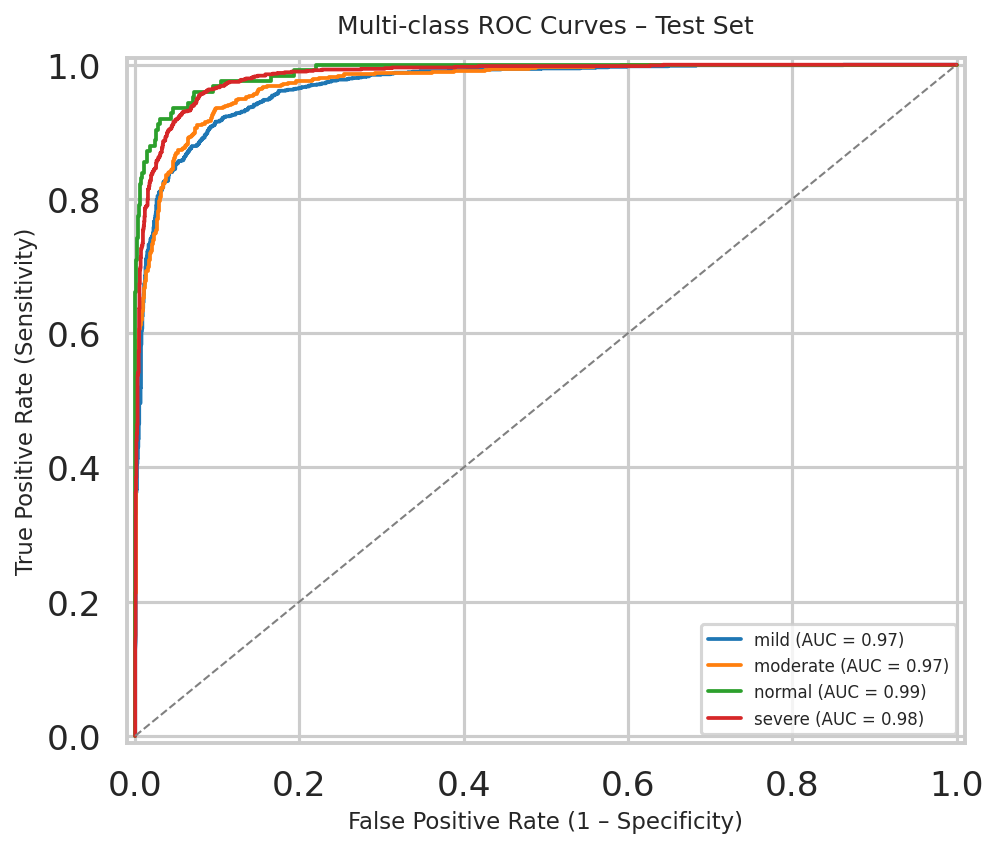

In [ ]:
# ==========================================
# 7b. Multi-class ROC Curves for Test Set
# ==========================================

n_classes = len(class_names)
# Convert true labels into one-hot format (shape = [N_samples, n_classes])
all_labels_onehot_test = label_binarize(all_labels_test, classes=np.arange(n_classes))

plt.figure(figsize=(7, 6), dpi=150)
for i, cls in enumerate(class_names):
    # Compute False Positive Rate (FPR) & True Positive Rate (TPR) at various thresholds
    fpr, tpr, _ = roc_curve(all_labels_onehot_test[:, i], all_probs_test[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr, tpr,
        linewidth=1.8,
        label=f"{cls} (AUC = {roc_auc:.2f})"
    )

# Plot diagonal reference line (chance = straight line from (0,0) to (1,1))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate (1 – Specificity)", fontsize=11)
plt.ylabel("True Positive Rate (Sensitivity)", fontsize=11)
plt.title("Multi-class ROC Curves – Test Set", fontsize=12, pad=12)
plt.legend(loc="lower right", fontsize=8, frameon=True)
plt.tight_layout()
plt.savefig("roc_curves_test.png", bbox_inches='tight', dpi=300)
plt.show()

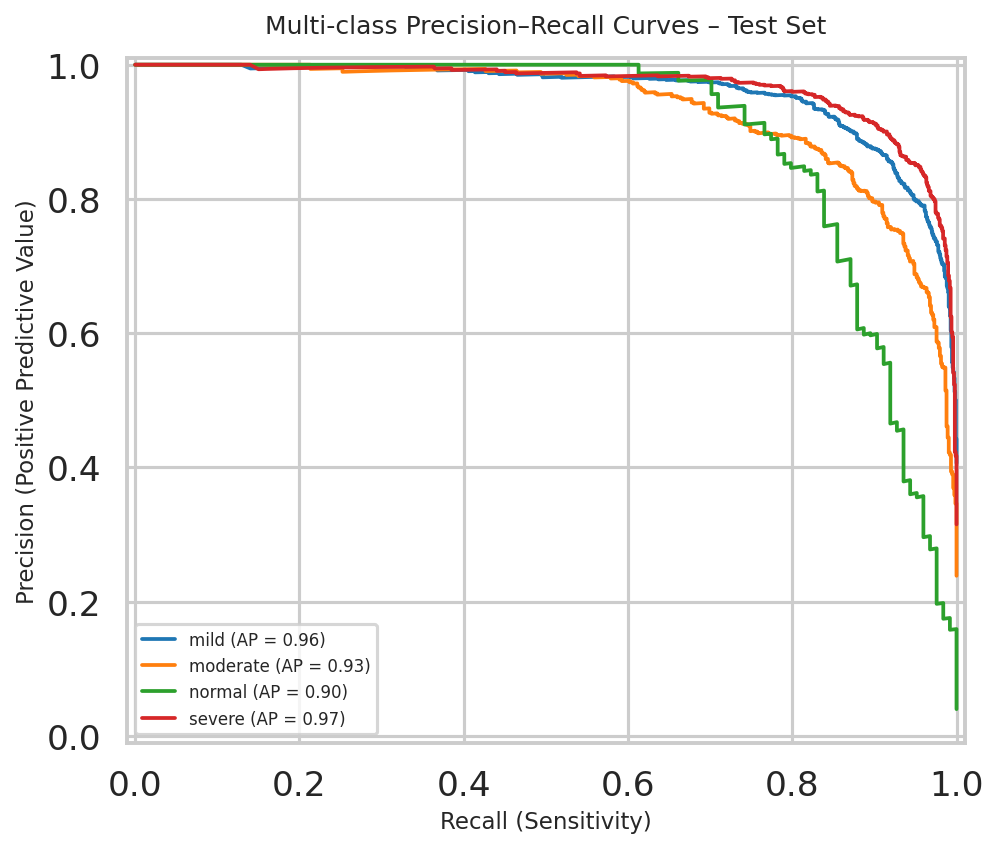

In [ ]:
# =======================================================
# 7c. Multi-class Precision–Recall Curves for Test Set
# =======================================================

plt.figure(figsize=(7, 6), dpi=150)
for i, cls in enumerate(class_names):
    # Compute precision & recall values at various thresholds
    precision_vals, recall_vals, _ = precision_recall_curve(
        all_labels_onehot_test[:, i],
        all_probs_test[:, i]
    )
    ap_score = average_precision_score(all_labels_onehot_test[:, i], all_probs_test[:, i])
    plt.plot(
        recall_vals, precision_vals,
        linewidth=1.8,
        label=f"{cls} (AP = {ap_score:.2f})"
    )

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Recall (Sensitivity)", fontsize=11)
plt.ylabel("Precision (Positive Predictive Value)", fontsize=11)
plt.title("Multi-class Precision–Recall Curves – Test Set", fontsize=12, pad=12)
plt.legend(loc="lower left", fontsize=8, frameon=True)
plt.tight_layout()
plt.savefig("pr_curves_test.png", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# ==============================
# 8. BALANCED TEST EVALUATION
# ==============================

model.eval()

all_preds_bal  = []
all_labels_bal = []
all_probs_bal  = []
correct_bal, total_bal = 0, 0

with torch.no_grad():
    for images, labels in balanced_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, dim=1)

        total_bal   += labels.size(0)
        correct_bal += (predicted == labels).sum().item()

        all_preds_bal.append(predicted.cpu())
        all_labels_bal.append(labels.cpu())
        all_probs_bal.append(probs.cpu())

accuracy_bal = 100 * correct_bal / total_bal
print(f"\nBalanced Test Accuracy: {accuracy_bal:.2f}%")

all_preds_bal  = torch.cat(all_preds_bal).numpy()
all_labels_bal = torch.cat(all_labels_bal).numpy()
all_probs_bal  = torch.cat(all_probs_bal).numpy()

precision_bal = precision_score(all_labels_bal, all_preds_bal, average='macro', zero_division=0)
recall_bal    = recall_score(all_labels_bal, all_preds_bal, average='macro', zero_division=0)
f1_bal        = f1_score(all_labels_bal, all_preds_bal, average='macro', zero_division=0)

print(f"Balanced Test Precision (macro): {precision_bal:.4f}")
print(f"Balanced Test Recall    (macro): {recall_bal:.4f}")
print(f"Balanced Test F1-Score   (macro): {f1_bal:.4f}\n")

print("Balanced Test: Per-class Precision / Recall / F1:\n")
print(classification_report(
    all_labels_bal,
    all_preds_bal,
    target_names=balanced_dataset.classes,
    zero_division=0
))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Balanced Test Accuracy: 85.50%
Balanced Test Precision (macro): 0.8703
Balanced Test Recall    (macro): 0.8550
Balanced Test F1-Score   (macro): 0.8555

Balanced Test: Per-class Precision / Recall / F1:

              precision    recall  f1-score   support

        mild       0.75      0.94      0.84       100
    moderate       0.82      0.81      0.81       100
      normal       1.00      0.75      0.86       100
      severe       0.91      0.92      0.92       100

    accuracy                           0.85       400
   macro avg       0.87      0.85      0.86       400
weighted avg       0.87      0.85      0.86       400



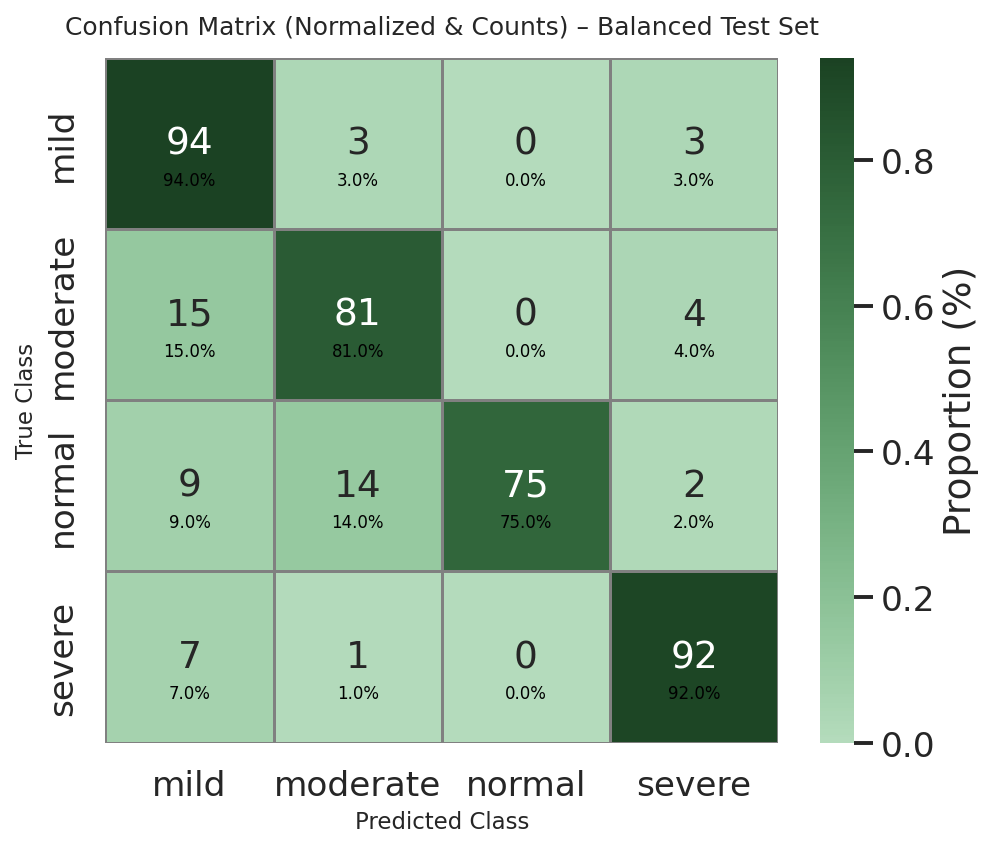

In [ ]:
# =============================================
# 8a. Confusion Matrix for Balanced Test Set
# =============================================

class_names_bal = balanced_dataset.classes

cm_bal = confusion_matrix(all_labels_bal, all_preds_bal)
cm_bal_norm = cm_bal.astype('float') / cm_bal.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(7, 6), dpi=150)
ax = sns.heatmap(
    cm_bal_norm,
    annot=cm_bal,
    fmt="d",
    cmap=cmap,
    cbar_kws={'label': 'Proportion (%)'},
    linewidths=0.5,
    linecolor='gray',
    xticklabels=class_names_bal,
    yticklabels=class_names_bal
)

for i in range(cm_bal.shape[0]):
    for j in range(cm_bal.shape[1]):
        pct = cm_bal_norm[i, j] * 100
        ax.text(
            j + 0.5, i + 0.65,
            f"\n{pct:.1f}%",
            ha="center",
            va="center",
            fontsize=8,
            color="black"
        )

ax.set_xlabel("Predicted Class", fontsize=11)
ax.set_ylabel("True Class", fontsize=11)
ax.set_title("Confusion Matrix (Normalized & Counts) – Balanced Test Set", fontsize=12, pad=12)
plt.tight_layout()
plt.savefig("confusion_matrix_balanced.png", bbox_inches='tight', dpi=300)
plt.show()

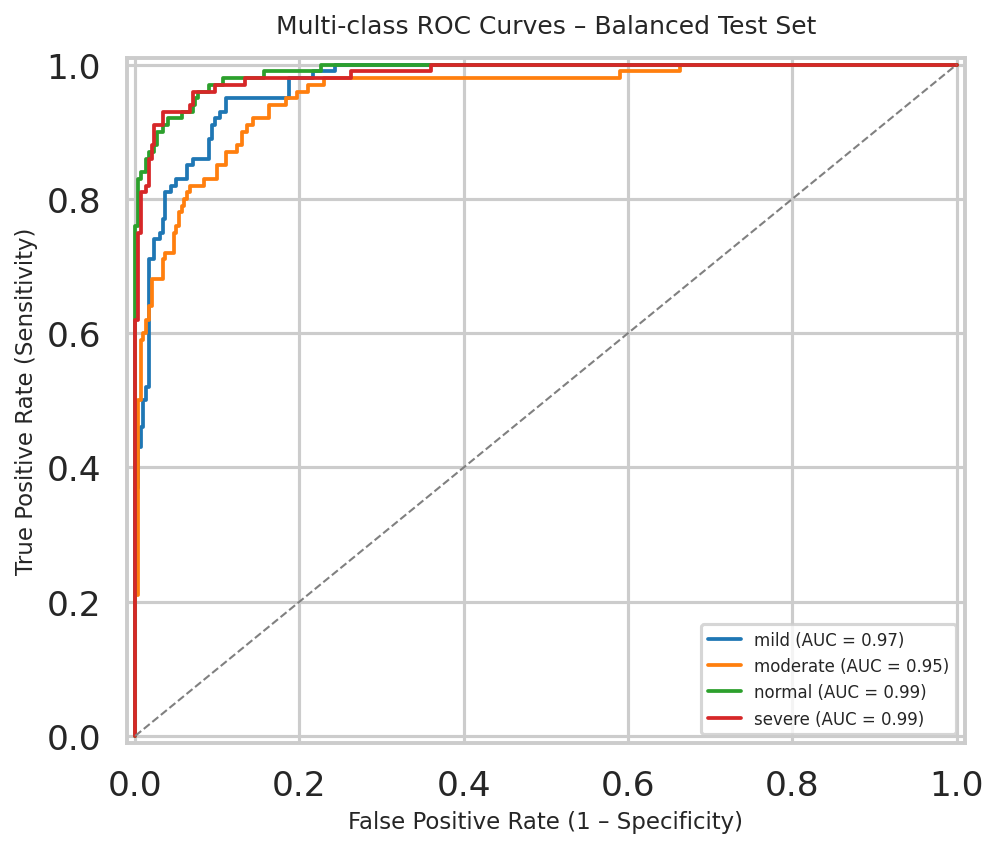

In [ ]:
# ===================================================
# 8b. Multi-class ROC Curves for Balanced Test Set
# ===================================================

all_labels_onehot_bal = label_binarize(all_labels_bal, classes=np.arange(n_classes))

plt.figure(figsize=(7, 6), dpi=150)
for i, cls in enumerate(class_names_bal):
    fpr, tpr, _ = roc_curve(all_labels_onehot_bal[:, i], all_probs_bal[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr, tpr,
        linewidth=1.8,
        label=f"{cls} (AUC = {roc_auc:.2f})"
    )

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate (1 – Specificity)", fontsize=11)
plt.ylabel("True Positive Rate (Sensitivity)", fontsize=11)
plt.title("Multi-class ROC Curves – Balanced Test Set", fontsize=12, pad=12)
plt.legend(loc="lower right", fontsize=8, frameon=True)
plt.tight_layout()
plt.savefig("roc_curves_balanced.png", bbox_inches='tight', dpi=300)
plt.show()

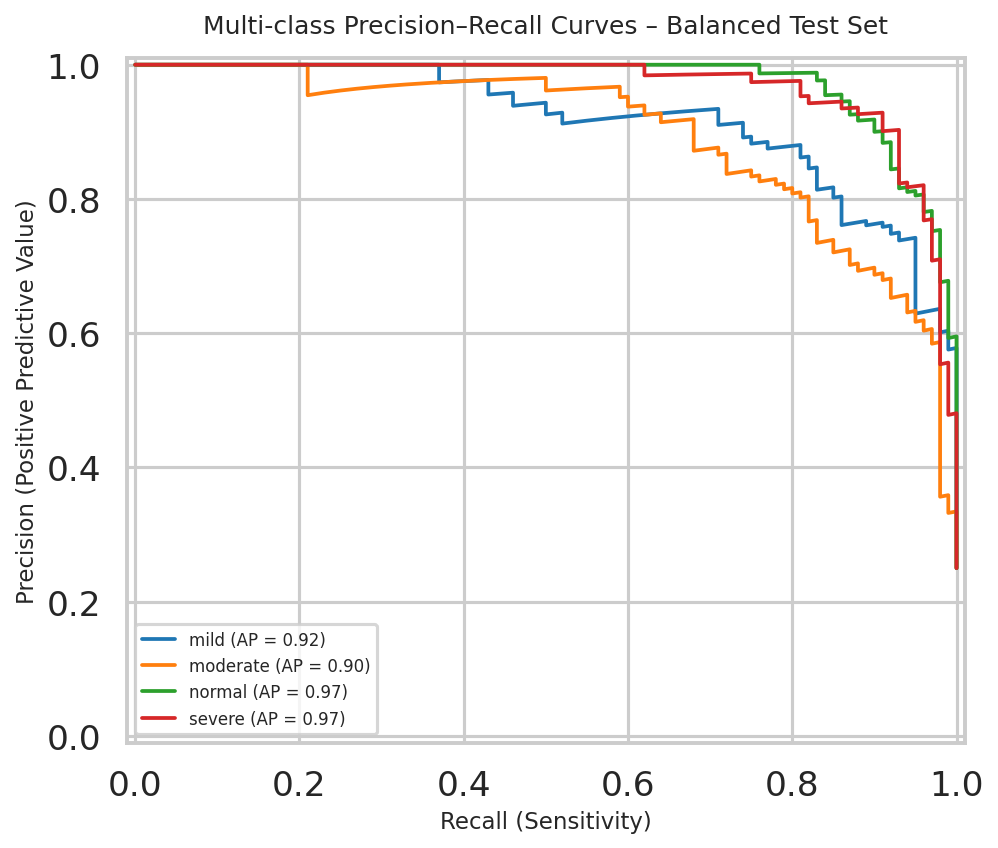

In [ ]:
# ================================================================
# 8c. Multi-class Precision–Recall Curves for Balanced Test Set
# ================================================================

plt.figure(figsize=(7, 6), dpi=150)
for i, cls in enumerate(class_names_bal):
    precision_vals, recall_vals, _ = precision_recall_curve(
        all_labels_onehot_bal[:, i],
        all_probs_bal[:, i]
    )
    ap_score = average_precision_score(all_labels_onehot_bal[:, i], all_probs_bal[:, i])
    plt.plot(
        recall_vals, precision_vals,
        linewidth=1.8,
        label=f"{cls} (AP = {ap_score:.2f})"
    )

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Recall (Sensitivity)", fontsize=11)
plt.ylabel("Precision (Positive Predictive Value)", fontsize=11)
plt.title("Multi-class Precision–Recall Curves – Balanced Test Set", fontsize=12, pad=12)
plt.legend(loc="lower left", fontsize=8, frameon=True)
plt.tight_layout()
plt.savefig("pr_curves_balanced.png", bbox_inches='tight', dpi=300)
plt.show()